In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from epam.dnsm import TransformerBinarySelectionModel, DNSMBurrito
from epam.sequences import translate_sequences

In [2]:
pcp_df = pd.read_csv("~/data/wyatt-10x-1p5m_pcp_2023-10-07.mimic-only_allow_mutations_at_hydrophobic_sites.csv")

# filter out rows of pcp_df where the parent and child sequences are identical
pcp_df = pcp_df[pcp_df["parent"] != pcp_df["child"]]

# NOTE downsampling here
pcp_df = pcp_df.sample(5000, random_state=42)

print(f"We have {len(pcp_df)} PCPs.")

We have 100 PCPs.


In [3]:
shmple_weights_directory = "/Users/matsen/re/epam/data/shmple_weights/my_shmoof"
nhead = 4
dim_feedforward = 2048
layer_count = 3

dnsm = TransformerBinarySelectionModel(
    nhead=nhead, dim_feedforward=dim_feedforward, layer_count=layer_count
)

burrito = DNSMBurrito(pcp_df, shmple_weights_directory, dnsm, batch_size=1024, learning_rate=0.001, checkpoint_dir="./_checkpoints", log_dir="./_logs")

Using Metal Performance Shaders
preparing data...


predicting mutabilities and substitutions...
consolidating this into substitution probabilities...
predicting mutabilities and substitutions...
consolidating this into substitution probabilities...


In [4]:
def selection_factor_plot(model):
    parents = pcp_df.reset_index(drop=True)["parent"]
    if len(parents) > 1000:
        parents = parents.sample(1000)
    aa_parents = translate_sequences(parents)
    selection_factor_arrays = [model.selection_factors_of_aa_str(aa_str).cpu().numpy() for aa_str in aa_parents]

    hydrophobic_aas = set(list("AILMFWV"))
    # "control": random AAs
    # hydrophobic_aas = set(list("RKLFMTG"))

    def selection_factor_means(aa_str, selection_factor_array):
        hydrophobic_selection_factors = []
        other_selection_factors = []
        for aa, selection_factor in zip(aa_str, selection_factor_array):
            if aa in hydrophobic_aas:
                hydrophobic_selection_factors.append(selection_factor)
            else:
                other_selection_factors.append(selection_factor)
        return {"hydrophobic_selection_mean": np.mean(np.array(hydrophobic_selection_factors)),
                "other_selection_mean": np.mean(np.array(other_selection_factors))}

    df = pd.DataFrame([selection_factor_means(aa_str, selection_factor_array) for aa_str, selection_factor_array in zip(aa_parents, selection_factor_arrays)])

    # Scatter plot
    plt.scatter(df['hydrophobic_selection_mean'], df['other_selection_mean'], label='sequences', alpha=0.1)
    plt.xlabel('Hydrophobic Selection Mean')
    plt.ylabel('Other Selection Mean')

    # Add x=y line
    lims = [
        np.min([plt.xlim(), plt.ylim()]),  
        np.max([plt.xlim(), plt.ylim()]),  
    ]
    plt.plot(lims, lims, 'k--', alpha=0.5, label='x=y line')
    plt.xlim(lims)
    plt.ylim(lims)

    plt.legend()
    plt.show()


In [5]:
burrito.train(15)
burrito.optimize_branch_lengths()
burrito.train(15)
burrito.optimize_branch_lengths()
burrito.train(50)

Epoch [0/3], Training Loss: 0.17340809106826782, Validation Loss: 0.20514585077762604
training model...
Epoch [1/3], Training Loss: 0.17328110337257385, Validation Loss: 0.18573862314224243
Epoch [2/3], Training Loss: 0.1645607203245163, Validation Loss: 0.1761293262243271
Epoch [3/3], Training Loss: 0.16764122247695923, Validation Loss: 0.16499878466129303


Finding optimal branch lengths: 100%|██████████| 80/80 [00:15<00:00,  5.04it/s]


predicting mutabilities and substitutions...
consolidating this into substitution probabilities...


Finding optimal branch lengths: 100%|██████████| 20/20 [00:02<00:00,  6.72it/s]


predicting mutabilities and substitutions...
consolidating this into substitution probabilities...
Epoch [0/3], Training Loss: 0.16393545269966125, Validation Loss: 0.16610592603683472
training model...
Epoch [1/3], Training Loss: 0.15989601612091064, Validation Loss: 0.1838715821504593
Epoch [2/3], Training Loss: 0.161887988448143, Validation Loss: 0.19316749274730682
Epoch [3/3], Training Loss: 0.16553090512752533, Validation Loss: 0.18912167847156525


Finding optimal branch lengths:   0%|          | 0/80 [00:00<?, ?it/s]/Users/matsen/re/epam/epam/models.py:351: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_branch_length = torch.tensor(np.log(base_branch_length), requires_grad=True)
Finding optimal branch lengths: 100%|██████████| 80/80 [00:11<00:00,  6.67it/s]


predicting mutabilities and substitutions...
consolidating this into substitution probabilities...


Finding optimal branch lengths: 100%|██████████| 20/20 [00:02<00:00,  6.85it/s]


predicting mutabilities and substitutions...
consolidating this into substitution probabilities...
Epoch [0/50], Training Loss: 0.1555190533399582, Validation Loss: 0.17963556945323944
training model...
Epoch [1/50], Training Loss: 0.1544167548418045, Validation Loss: 0.171417698264122
Epoch [2/50], Training Loss: 0.15401028096675873, Validation Loss: 0.1655021458864212
Epoch [3/50], Training Loss: 0.15480944514274597, Validation Loss: 0.1634209305047989
Epoch [4/50], Training Loss: 0.15359628200531006, Validation Loss: 0.16739238798618317
Epoch [5/50], Training Loss: 0.15116360783576965, Validation Loss: 0.17112834751605988
Epoch [6/50], Training Loss: 0.15010154247283936, Validation Loss: 0.17259187996387482
Epoch [7/50], Training Loss: 0.1504330337047577, Validation Loss: 0.17032690346240997
Epoch [8/50], Training Loss: 0.149882510304451, Validation Loss: 0.1671086698770523
Epoch [9/50], Training Loss: 0.15035508573055267, Validation Loss: 0.16592226922512054
Epoch [10/50], Training

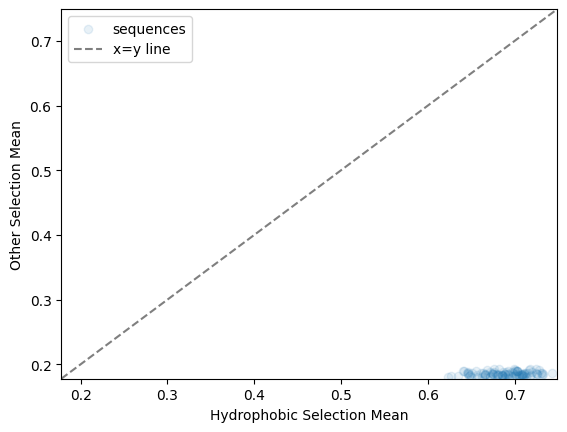

In [6]:
selection_factor_plot(burrito.dnsm)

In [7]:
[aa_str] = translate_sequences([pcp_df.reset_index(drop=True).loc[0, "parent"]])
burrito.dnsm.selection_factors_of_aa_str(aa_str)

tensor([0.1844, 0.9990, 0.1820, 0.9990, 0.8243, 0.2199, 0.1799, 0.1630, 0.1718,
        0.4132, 0.9990, 0.3986, 0.2855, 0.1708, 0.2079, 0.5724, 0.2531, 0.8543,
        0.2087, 0.4280, 0.1659, 0.1680, 0.1715, 0.1898, 0.1708, 0.1653, 0.1653,
        0.1642, 0.8265, 0.1676, 0.1869, 0.1742, 0.1675, 0.9990, 0.1739, 0.9990,
        0.3111, 0.1671, 0.1699, 0.8141, 0.1660, 0.1676, 0.2199, 0.1741, 0.5752,
        0.2085, 0.9990, 0.7706, 0.2273, 0.9990, 0.9990, 0.1819, 0.1665, 0.1846,
        0.1685, 0.1780, 0.1787, 0.1679, 0.1658, 0.1811, 0.1949, 0.2075, 0.1867,
        0.7388, 0.1660, 0.1676, 0.1679, 0.7954, 0.2039, 0.5452, 0.1652, 0.4800,
        0.1656, 0.1650, 0.1772, 0.2164, 0.1683, 0.1647, 0.6777, 0.2371, 0.9990,
        0.1929, 0.9990, 0.1686, 0.1738, 0.7437, 0.2178, 0.1824, 0.3384, 0.1661,
        0.1660, 0.3286, 0.6006, 0.3503, 0.2257, 0.1688, 0.4630, 0.1700, 0.1670,
        0.1690, 0.1932, 0.1638, 0.3740, 0.2019, 0.1647, 0.1667, 0.1662, 0.1668,
        0.9990, 0.8766, 0.1662, 0.1678, 

In [8]:
# nhead = 4
# dim_feedforward = 2048
# layer_count = 3
# 
# model = TransformerBinarySelectionModel(
#     nhead=nhead, dim_feedforward=dim_feedforward, layer_count=layer_count
# )
# 
# model.load_state_dict(torch.load("../_trained_dnsms/dnsm-hydrophobic-2023-11-01.pth")["model_state_dict"])
# model.eval()



In [9]:
# model = TransformerBinarySelectionModel(
#     nhead=nhead, dim_feedforward=dim_feedforward, layer_count=layer_count
# )
nobl_trained_dnsm = TransformerBinarySelectionModel(
    nhead=nhead, dim_feedforward=dim_feedforward, layer_count=layer_count
)

nobl_trained_burrito = DNSMBurrito(pcp_df, shmple_weights_directory, nobl_trained_dnsm, batch_size=1024, learning_rate=0.001, checkpoint_dir="./_checkpoints", log_dir="./_logs")

nobl_trained_burrito.train(50)

model = nobl_trained_burrito.dnsm


Using Metal Performance Shaders
preparing data...


predicting mutabilities and substitutions...
consolidating this into substitution probabilities...
predicting mutabilities and substitutions...
consolidating this into substitution probabilities...
Epoch [0/50], Training Loss: 0.1734018325805664, Validation Loss: 0.2079601287841797
training model...
Epoch [1/50], Training Loss: 0.1742042899131775, Validation Loss: 0.19539965689182281
Epoch [2/50], Training Loss: 0.16796526312828064, Validation Loss: 0.1842506378889084
Epoch [3/50], Training Loss: 0.16574431955814362, Validation Loss: 0.1797008216381073
Epoch [4/50], Training Loss: 0.16359655559062958, Validation Loss: 0.1634419560432434
Epoch [5/50], Training Loss: 0.15909530222415924, Validation Loss: 0.15688608586788177
Epoch [6/50], Training Loss: 0.15559209883213043, Validation Loss: 0.1607673317193985
Epoch [7/50], Training Loss: 0.1558229923248291, Validation Loss: 0.16764065623283386
Epoch [8/50], Training Loss: 0.15692104399204254, Validation Loss: 0.1634584218263626
Epoch [9/5

In [10]:
nofrac_dnsm = TransformerBinarySelectionModel(
    nhead=nhead, dim_feedforward=dim_feedforward, layer_count=layer_count
)

nofrac_burrito = DNSMBurrito(pcp_df, shmple_weights_directory, nofrac_dnsm, batch_size=1024, learning_rate=0.001, checkpoint_dir="./_checkpoints", log_dir="./_logs")

nofrac_burrito.train(10)
# nofrac_burrito.optimize_branch_lengths()
# for dataset in [burrito.train_set, burrito.val_set]:
#     dataset.branch_lengths /= 2.
# nofrac_burrito.train(3)

Using Metal Performance Shaders
preparing data...


predicting mutabilities and substitutions...
consolidating this into substitution probabilities...
predicting mutabilities and substitutions...
consolidating this into substitution probabilities...
Epoch [0/10], Training Loss: 0.17378811538219452, Validation Loss: 0.20674920082092285
training model...
Epoch [1/10], Training Loss: 0.17431458830833435, Validation Loss: 0.19815205037593842
Epoch [2/10], Training Loss: 0.17411287128925323, Validation Loss: 0.19169186055660248
Epoch [3/10], Training Loss: 0.16687354445457458, Validation Loss: 0.19038760662078857
Epoch [4/10], Training Loss: 0.16680002212524414, Validation Loss: 0.18129479885101318
Epoch [5/10], Training Loss: 0.16312463581562042, Validation Loss: 0.17140911519527435
Epoch [6/10], Training Loss: 0.16287818551063538, Validation Loss: 0.16454164683818817
Epoch [7/10], Training Loss: 0.16000905632972717, Validation Loss: 0.16038361191749573
Epoch [8/10], Training Loss: 0.15824443101882935, Validation Loss: 0.16246499121189117
E

predicting mutabilities and substitutions...
consolidating this into substitution probabilities...
predicting mutabilities and substitutions...
consolidating this into substitution probabilities...
Epoch [0/10], Training Loss: 0.15981662273406982, Validation Loss: 0.16223441064357758
training model...
Epoch [1/10], Training Loss: 0.1564849466085434, Validation Loss: 0.1587843894958496
Epoch [2/10], Training Loss: 0.16061198711395264, Validation Loss: 0.1559143364429474
Epoch [3/10], Training Loss: 0.15732192993164062, Validation Loss: 0.1559540033340454
Epoch [4/10], Training Loss: 0.15978331863880157, Validation Loss: 0.15662644803524017
Epoch [5/10], Training Loss: 0.155989408493042, Validation Loss: 0.15614520013332367
Epoch [6/10], Training Loss: 0.1547783762216568, Validation Loss: 0.15495850145816803
Epoch [7/10], Training Loss: 0.15573282539844513, Validation Loss: 0.15479151904582977
Epoch [8/10], Training Loss: 0.15367037057876587, Validation Loss: 0.15441836416721344
Epoch [9

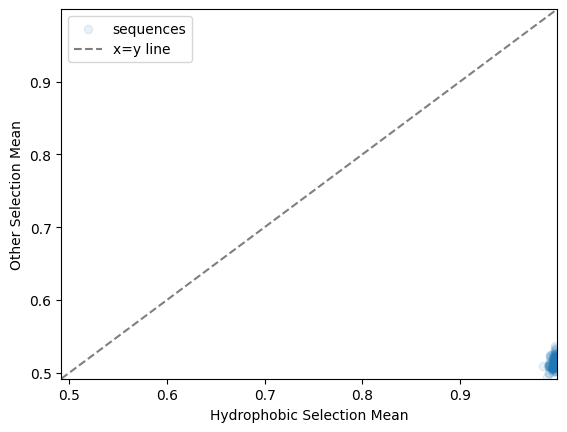

In [11]:
for dataset in [burrito.train_set, burrito.val_set]:
    dataset.branch_lengths /= 2.
nofrac_burrito.train(10)

selection_factor_plot(nofrac_burrito.dnsm)